In [83]:
import os
import glob

In [84]:
from matplotlib import pyplot as plt

In [85]:
import numpy as np
import pandas as pd

In [86]:
import sklearn
from xgboost import XGBClassifier

## Load data

In [87]:
glob.glob('data/*', recursive=True)

['data/bank-additional-full.csv',
 'data/bank-additional.csv',
 'data/bank-additional-names.txt']

In [144]:
data = pd.read_csv('data/bank-additional-full.csv', sep=';')
#drop duration because of reverse causality (suggeted by the Author)
data = data.drop(columns = ['duration'])
data['y_numeric'] = data['y'].map({'yes':1, 'no':0})

In [145]:
from calendar import month_abbr

lower_ma = [m.lower() for m in month_abbr]

# one-liner with Pandas
data['month'] = data['month'].map(lambda m: lower_ma.index(m)).astype('Int8')

In [146]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,y_numeric
0,56,housemaid,married,basic.4y,no,no,no,telephone,5,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
1,57,services,married,high.school,unknown,no,no,telephone,5,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
2,37,services,married,high.school,no,yes,no,telephone,5,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
3,40,admin.,married,basic.6y,no,no,no,telephone,5,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
4,56,services,married,high.school,no,no,yes,telephone,5,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0


In [147]:
numeric_columns = [
    'age',
    'campaign',
    'emp.var.rate',
    'cons.price.idx',
    'cons.conf.idx',
    'euribor3m',
    'nr.employed'    
]
categorical_columns = [col for col in data.columns if col not in numeric_columns]
categorical_columns

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'pdays',
 'previous',
 'poutcome',
 'y',
 'y_numeric']

## Target Variable

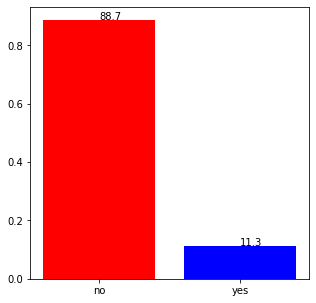

In [148]:
target = (data['y'].value_counts()/data['y'].count()).to_frame()
x = target.index.values
y = target.y.values
fig, ax = plt.subplots(1,1, figsize = [5,5])
ax.bar(x,y, color=['r','b'])
for i,j in zip(x,y):
    ax.annotate(str(round(j*100,1)),xy=(i,j))

## Analyzing features

### Demographic features

In [149]:
from scipy.stats import percentileofscore
bin_num = 10
data['age_group'] = pd.qcut(data['age'], q = bin_num, labels = range(0,bin_num))

In [150]:
data['education'].value_counts()
data['education_group']= data['education'].map(
    {
        'illiterate':'basic or none',
        'basic.4y':'basic or none',
        'basic.6y':'basic or none',
        'basic.9y':'basic or none',
        'high.school':'high school or courses',
        'professional.course':'high school or courses',
        'university.degree': 'university degree',
        'unknown':'unknown'
    }
)

In [151]:
demographic_features = ['age_group', 'job', 'marital', 'education_group', 'housing', 'loan']

In [152]:
for col in demographic_features:
    print(f"-------------{col}-------------")
    print(data[col].value_counts().transform(lambda x: x/sum(x)*100))

-------------age_group-------------
1    12.416238
4    11.318831
8    10.859959
6    10.466641
0    10.235991
5     9.398368
7     9.167719
2     8.932213
9     8.696708
3     8.507332
Name: age_group, dtype: float64
-------------job-------------
admin.           25.303486
blue-collar      22.467709
technician       16.371273
services          9.636302
management        7.099155
retired           4.175974
entrepreneur      3.535010
self-employed     3.450034
housemaid         2.573565
unemployed        2.461882
student           2.124405
unknown           0.801204
Name: job, dtype: float64
-------------marital-------------
married     60.522482
single      28.085850
divorced    11.197436
unknown      0.194231
Name: marital, dtype: float64
-------------education_group-------------
high school or courses    35.830825
basic or none             30.423910
university degree         29.542585
unknown                    4.202680
Name: education_group, dtype: float64
-------------housing------

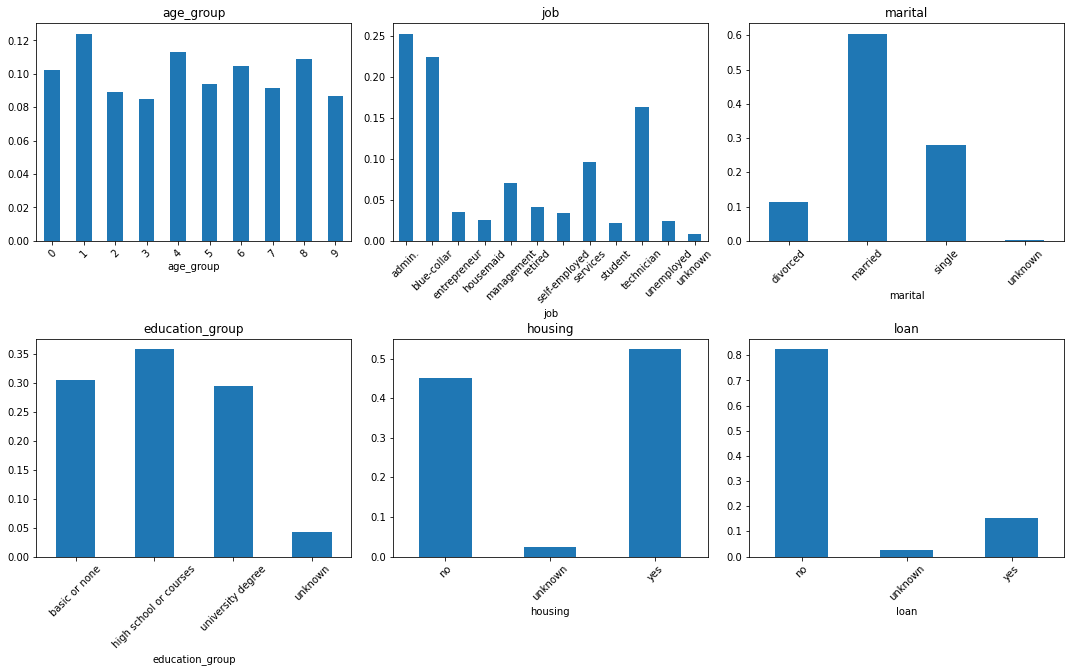

In [169]:
fig, axs = plt.subplots(2,3, figsize = [15, 8])
fig.tight_layout() 
for i, col in enumerate(demographic_features):
    ax = axs[i//3, i%3]
    ax.set_title(col)
    (data.groupby(col)['y'].count()/len(data)).plot(kind='bar', ax=ax, rot = 45)
fig.subplots_adjust(hspace=.45)    

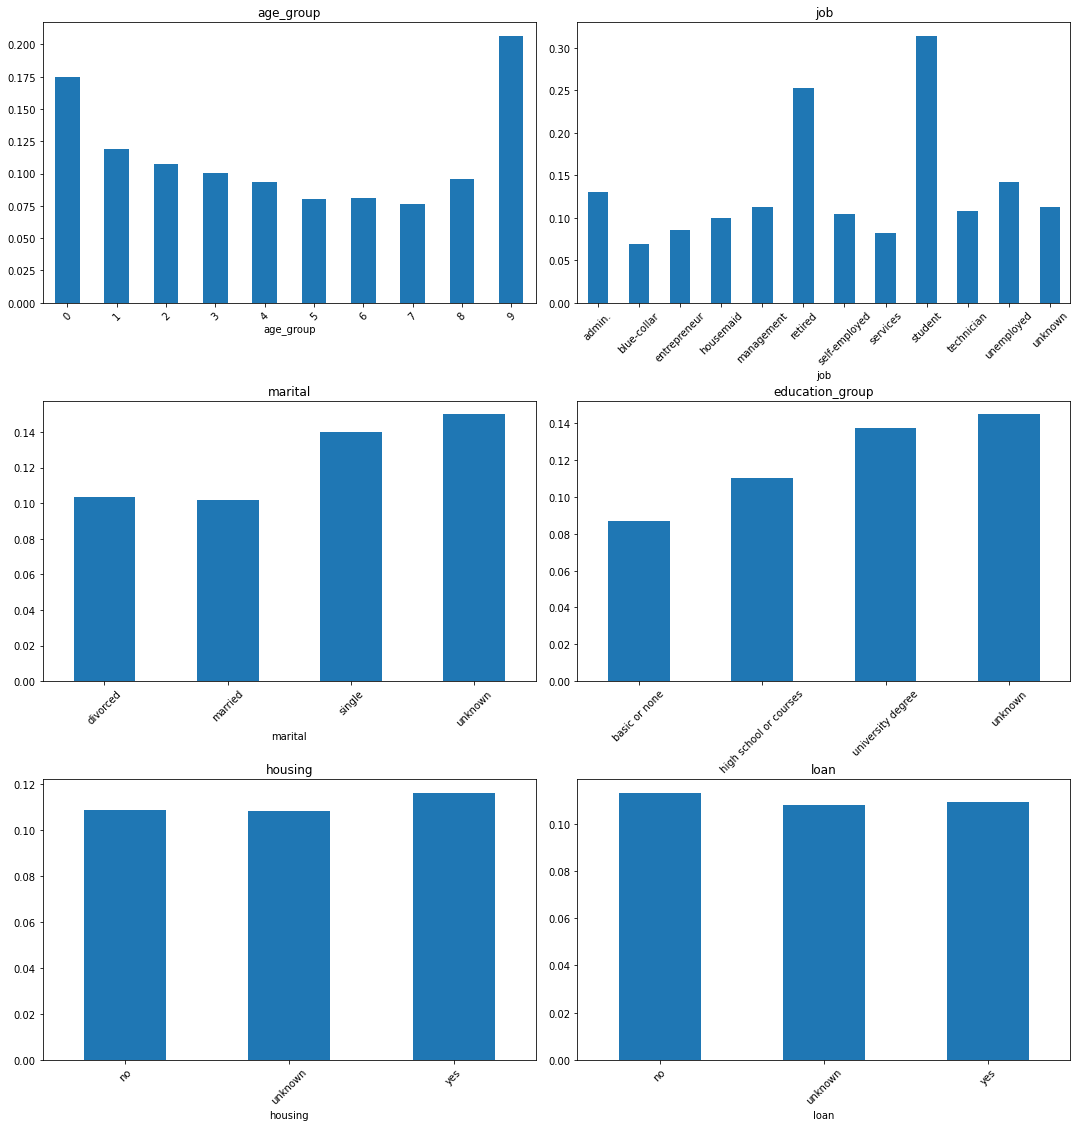

In [154]:
fig, axs = plt.subplots(3,2, figsize = [15, 15])
fig.tight_layout() 
for i, col in enumerate(demographic_features):
    ax = axs[i//2, i%2]
    ax.set_title(col)
    #data[col].hist(ax=ax, xrot = 45)
    data.groupby(col)['y_numeric'].mean().plot(kind = 'bar', ax=ax, rot = 45)
fig.subplots_adjust(hspace=.35)  

In [155]:
data.groupby(col)['y_numeric'].mean()

loan
no         0.113402
unknown    0.108081
yes        0.109315
Name: y_numeric, dtype: float64

#### 'Defaul' feature

In [156]:
data.pivot_table(index = 'default', values = 'y', aggfunc='count')

,y
default,
no,32588
unknown,8597
yes,3


##### It seems that dropping it would be safer

In [157]:
demographic_features_final = ['job', 'marital', 'education', 'housing', 'loan']

### Campain features

In [158]:
campaing_features = ['contact', 'month', 'day_of_week']from calendar import month_abbr

lower_ma = [m.lower() for m in month_abbr]

# one-liner with Pandas
df['MONTH'] = df['MONTH'].str.lower().map(lambda m: lower_ma.index(m)).astype('Int8')


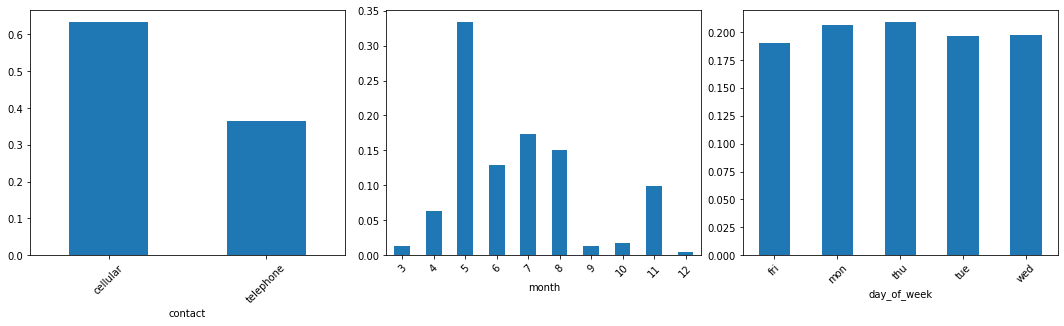

In [173]:
fig, axs = plt.subplots(1,3, figsize = [15, 4])
fig.tight_layout() 
for i in range(3):
    (data.groupby(campaing_features[i])['y'].count()/len(data)).plot(kind='bar', ax=axs[i], rot = 45)
fig.subplots_adjust(hspace=.25)   

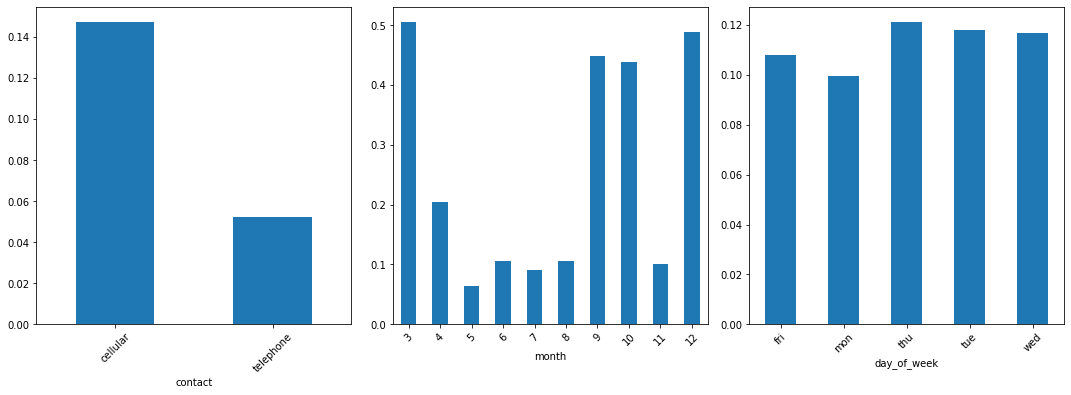

In [160]:
fig, axs = plt.subplots(1,3, figsize = [15, 5])
fig.tight_layout() 
for i in range(3):
    data.groupby(campaing_features[i])['y_numeric'].mean().plot(kind = 'bar', ax=axs[i], rot = 45)
fig.subplots_adjust(hspace=.35) 

### Other features

In [ ]:
other_features = ['campaing', 'pdays', 'outcome']

### Dropping uknowns

In [331]:
for col in demographic_features:
    data[col] = data[col].apply(lambda x: np.nan if x == 'unknown' else x)

In [332]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   age              41188 non-null  int64   
 1   job              40858 non-null  object  
 2   marital          41108 non-null  object  
 3   education        41188 non-null  object  
 4   housing          40198 non-null  object  
 5   loan             40198 non-null  object  
 6   contact          41188 non-null  object  
 7   month            41188 non-null  object  
 8   day_of_week      41188 non-null  object  
 9   campaign         41188 non-null  int64   
 10  pdays            41188 non-null  int64   
 11  previous         41188 non-null  int64   
 12  poutcome         41188 non-null  object  
 13  emp.var.rate     41188 non-null  float64 
 14  cons.price.idx   41188 non-null  float64 
 15  cons.conf.idx    41188 non-null  float64 
 16  euribor3m        41188 non-null  float64

In [333]:
print(f"full dataset size is {len(data)} and dropping uknowns reduces it to {len(data.dropna())}")

full dataset size is 41188 and dropping uknowns reduces it to 38245


In [337]:
data['y'].mean()/data.dropna()['y'].mean()

1.0118503462659256

NameError: name 'demographic_features' is not defined

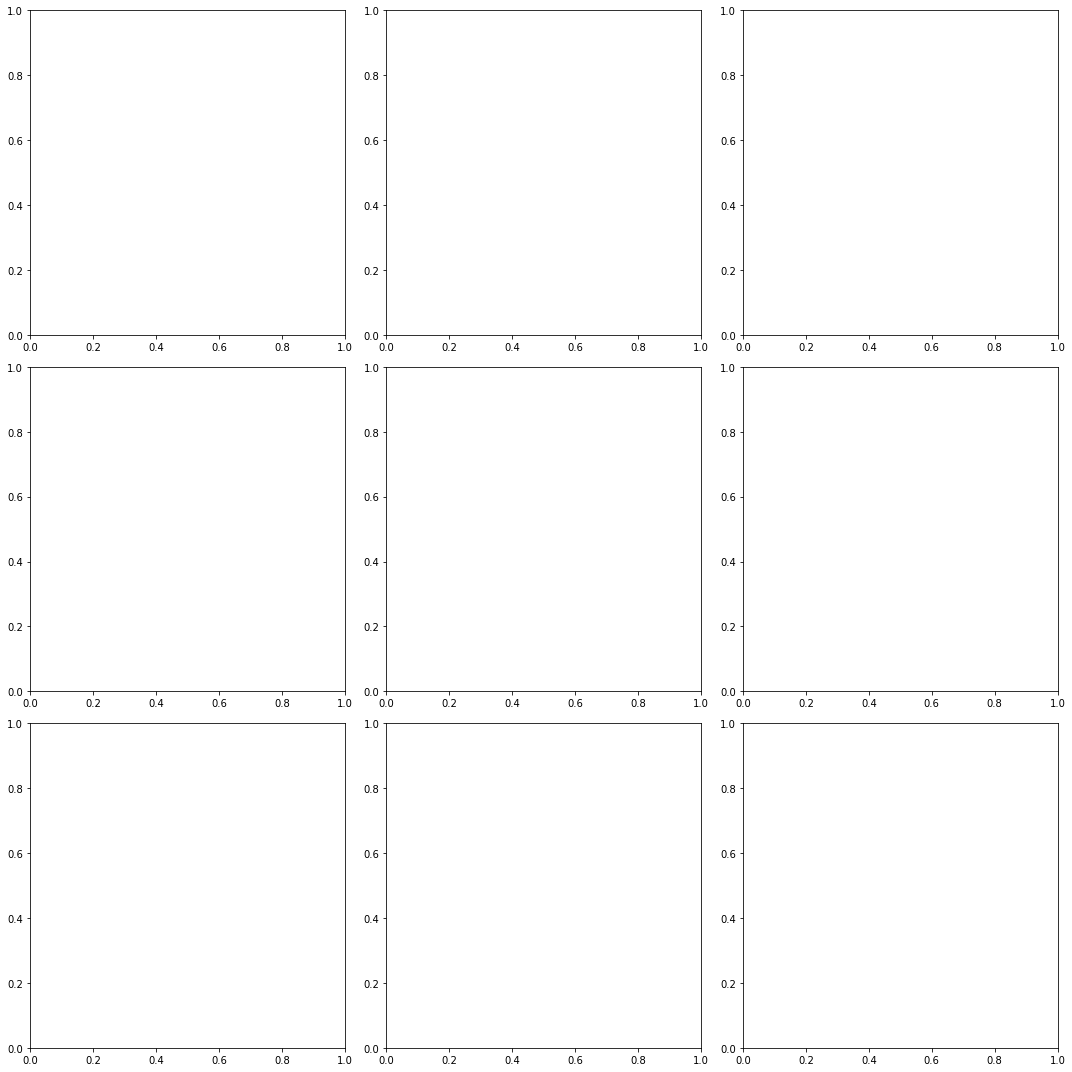

In [81]:
fig, axs = plt.subplots(3,3, figsize = [15, 15])
fig.tight_layout() 
for i, col in enumerate(demographic_features):
    ax = axs[i//3, i%3]
    ax.set_title(col)
    #data[col].hist(ax=ax, xrot = 45)
    data.groupby(col)['y'].mean().plot(kind='bar', ax=ax) #, xrot = 45)
fig.subplots_adjust(hspace=.25)  

In [208]:
# for col in data.columns:
#     data[col] = data[col].apply(lambda x: np.nan if x == 'unknown' else x)

<AxesSubplot:xlabel='age_group'>

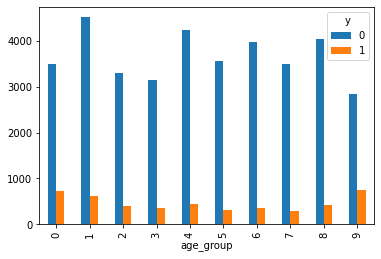

In [288]:
#data.groupby('job')['y'].count() #.sort_values(ascending=False).plot(kind='bar')
data.pivot_table(index = 'age_group', columns = 'y', values='age', aggfunc='count').plot(kind = 'bar')

In [ ]:
data['age_category'] = 

In [178]:
data[numeric_columns].describe()

,age,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,2.567593,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,2.770014,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,1.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,1.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,2.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,3.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,56.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


<AxesSubplot:>

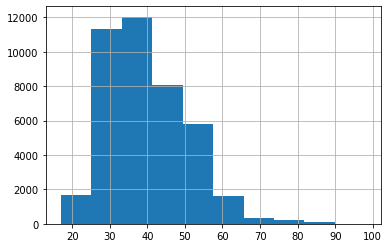

In [180]:
data['age'].hist()

In [ ]:
data['']

## preprocess categorical

In [ ]:
def drop_super_minorities(df):
    



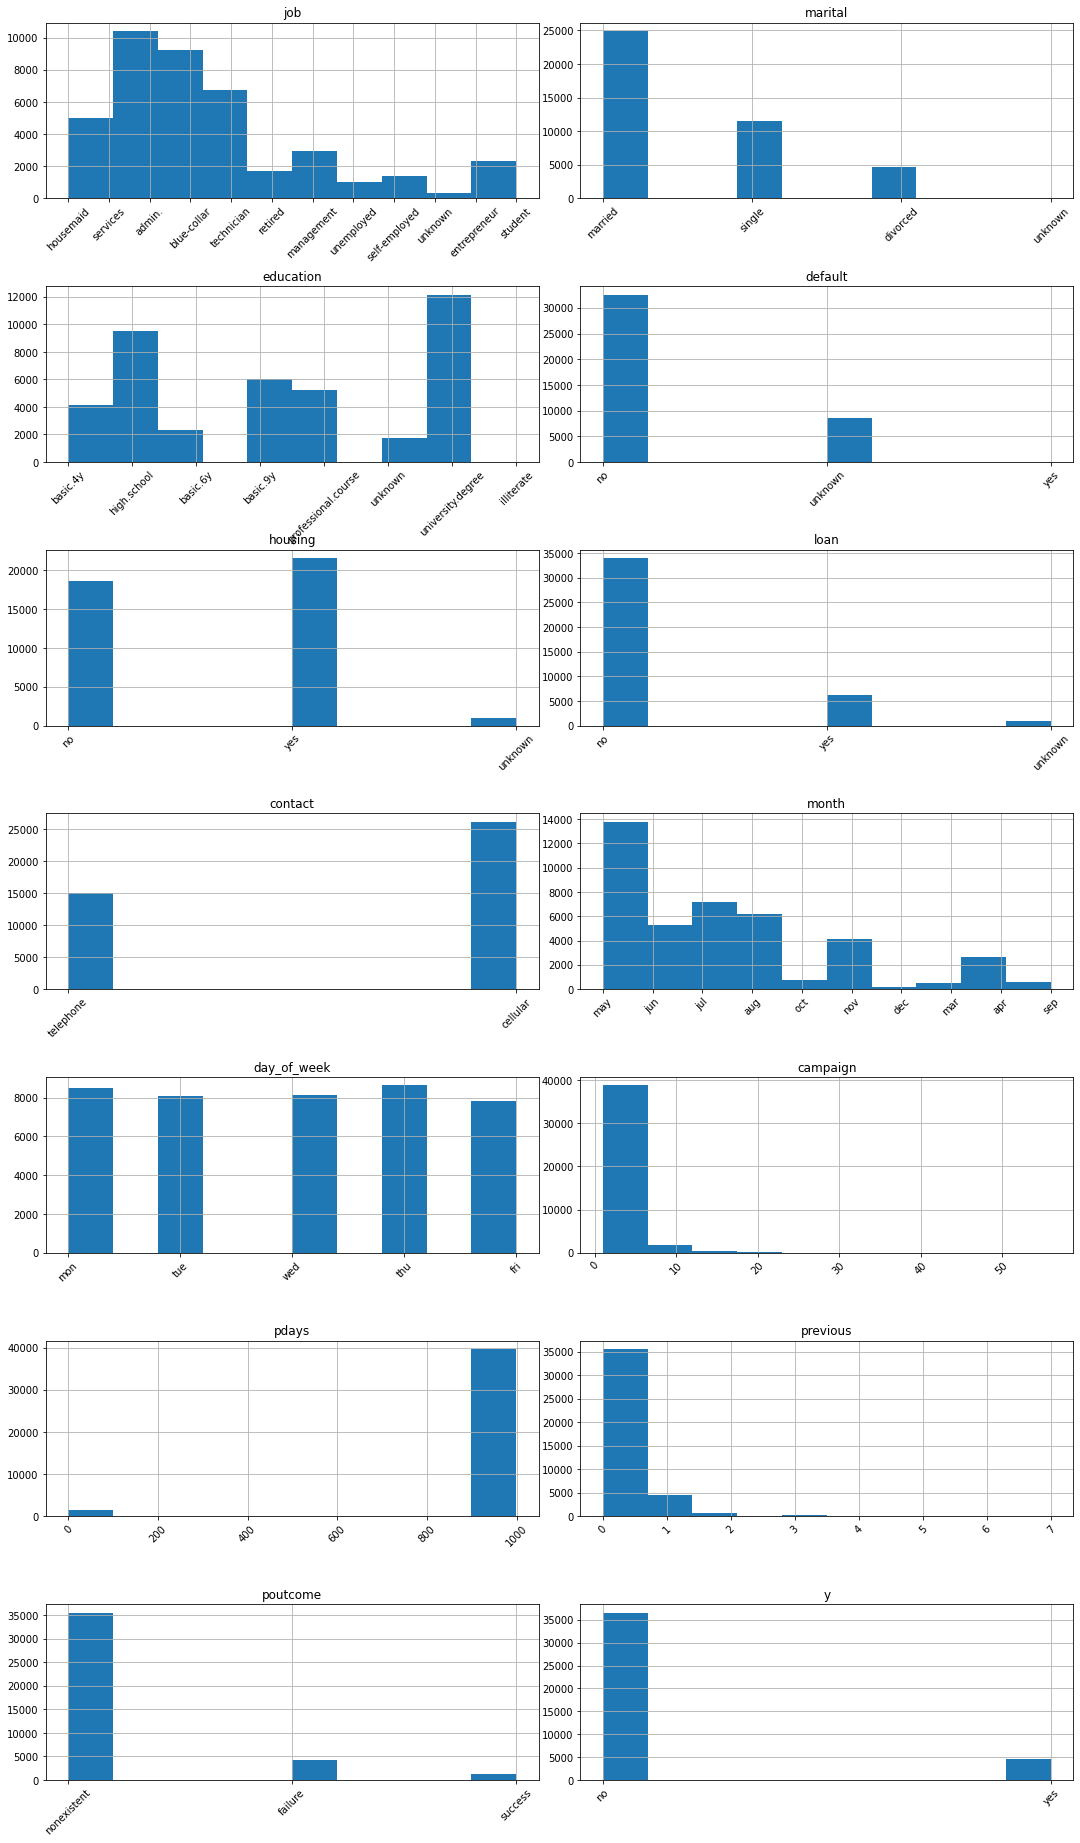

In [76]:
fig, axs = plt.subplots(7,2, figsize = [15, 25])
fig.tight_layout() 
for i, col in enumerate(categorical_columns):
    ax = axs[i//2, i%2]
    ax.set_title(col)
    data[col].hist(ax=ax, xrot = 45)
fig.subplots_adjust(hspace=.5)

In [92]:
from sklearn.preprocessing import LabelEncoder

In [93]:
encoder = OneHotEncoder(sparse=False)
encoded_data = encoder.fit_transform(data['marital'].values.reshape(-1,1))

In [94]:
encoded_data[:10].astype(int)

array([[0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0]])

In [97]:
encoder.get_feature_names(['marital'])

array(['marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown'], dtype=object)

In [104]:
data['marital'].value_counts(normalize=True).index.tolist()

['married', 'single', 'divorced', 'unknown']

In [149]:
def OneDropEncoder(df_col):
    #categories = df_col.value_counts(normalize=True).index.tolist()
    encoder = OneHotEncoder(sparse=False, drop='first')
    encoded_df = pd.DataFrame(data = encoder.fit_transform(df_col.to_frame()), columns=encoder.get_feature_names_out())
    return encoded_df
    

In [150]:
OneDropEncoder(data['marital'])

,marital_married,marital_single,marital_unknown
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
41183,1.0,0.0,0.0
41184,1.0,0.0,0.0
41185,1.0,0.0,0.0
41186,1.0,0.0,0.0


In [153]:
def add_or_apppend_df(df1, df2):
    if len(df1) == 0:
        return df2
    else:
        return pd.concat(df1, df2, axis = 0)

In [154]:
from sklearn.model_selection import train_test_split

In [158]:
train_df, test_df = train_test_split(data, test_size = 0.2, stratify = data[categorical_columns])

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [162]:
data['marital'].value_counts()

married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64